# Using 2D CNN for Image Classification on MNIST

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import csv
import ipdb
import sys
import numpy as np
import base64
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## Utility Functions:


In [2]:

def getDataLoaders():
    """ Function to get MNIST data

        Returns:
            trainloader: Dataloader for train dataset
            testloader: Dataloader for test dataset
            trainset
            testset
    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])

    trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                          download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                              shuffle=True)

    testset = torchvision.datasets.MNIST(root='../data', train=False,
                                         download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                             shuffle=False)

    return trainset, testset, trainloader, testloader


def vizImages(trainset):

    """ Function to visualize sample training images
        Arguments:
            trainloader: Dataloader for train dataset
 
        TO-DO:
        1. Use plt.subplots() and show an image in each subplot
        2. Make sure there is at least 1 image from each class
    """
    num_list = []
    print_list = []
    j = 0
    
    for i in range(20):
        num_label = int(trainset[i][1])
        
        if num_label not in num_list:
            num_list.append(num_label)
            print_list.append(trainset.train_data[i].numpy())
            j = j + 1
            
        else:
            continue
            
    k =0
    plt.figure(0)
    for i in range(2):
        for j in range(5):
            plt.subplot2grid((2,5), (i,j))
            plt.imshow(print_list[k], cmap='gray')
            plt.title('%i' % num_list[k])
            k = k + 1
            
    plt.show()
    #return 0


def getClassAcc(testloader, net, pred_y, target_y, batch_size=1):

    """ Compute accuracy for each class

        Arguments:
            testloader: Dataloader for test dataset
            net: instance of the CNN class

         TO-DO:
         1. Enumerate over testloader
         2. Compute number of correct predictions for each class
         3. At the end, print the accuracy of each class
    """
    
    accuracy_all_class = []
    
    for k in range(10):
        idx = np.where(target_y == k)
        predict_class = pred_y[idx]
        accur_class = len(predict_class[predict_class == k]) / len(predict_class)
        accuracy_all_class.append(accur_class)
        print("class" + str(k) + "Accuracy : " + str(accur_class))
        
    return accuracy_all_class


def plotLossAcc(train_losses, test_losses, test_accuracies):

    """ Plot train and test results

        Arguments:
            train_losses: Train loss corresponding to each iteration
            test_losses: Test loss corresponding to each epoch
            test_accuracies: Test accuracy corresponding to each epoch

        TO-DO:
        1. Plot train loss v/s epoch
        2. Plot test accuracy v/s epoch
        3. Plot test loss v/s epoch
    """
    
    num_epoch = range(10)
    
    plt.plot(num_epoch, train_losses)
    plt.title("Train Loss VS Epoch_num")
    plt.show()

    plt.plot(num_epoch, test_losses)
    plt.title("Test Loss VS Epoch_num")
    plt.show()
    
    plt.plot(num_epoch, test_accuracies)
    plt.title("Test Accuracy VS Epoch_num")
    plt.show()
    

def vizConvWeights(net):

    """ Visualize weights of the convolution layers

        Arguments:
            net: instance of the CNN class
 
        TO-DO:
        1. Get the weights of conv1 layer. You'll have 10 kernels, each of dimension 5x5
        2. Create a subplot and visualize each kernel in a subplot
    """
    
    net_dict = net.state_dict()
    conv_1_wt = net_dict['conv1.0.weight'].numpy()
    conv_2_wt = net_dict['conv2.0.weight'].numpy()
    
    # VISUALIZE Conv_1:
    
    fig1 = plt.figure(figsize=(9, 9))
    plt.title("conv_1_weights")
    num_columns = 5
    num_rows = 2
    
    for i in range(1, num_columns*num_rows + 1 ):
        
        img = conv_1_wt[i - 1][0]
        fig1.add_subplot(num_rows, num_columns, 1)
        plt.axis('off')
        plt.imshow(img, cmap="gray")
    plt.show()
    
    # VISUALIZE Conv_2:
    
    fig2 = plt.figure(figsize=(9, 9))
    plt.title("conv_2_weights")
    
    num_columns2 = 5
    num_rows2 = 4
    for j in range(1, num_columns2*num_rows2 + 1 ):
        
        img2 = conv_2_wt[j - 1][0]
        fig1.add_subplot(num_rows2, num_columns2, 1)
        plt.axis('off')
        plt.imshow(img, cmap="gray")
    plt.show()
    
def vizFeatureMaps(testloader, net,  f1, f2):

    """ Visualize weights of the convolution layers

        Arguments:
            testloader: Dataloader for test dataset
            net: instance of the CNN class

        TO-DO:
        1. Pass one image through the network and get its conv1 and conv2 features
        2. conv1: Get the features after conv1. There'll be 10 24x24 feature maps. Create a subplot and visualize them
        3. conv2: Get the features after conv2. There'll be 20 8x8 feature maps. Create a subplot and visualize them
    """
    
    feature_1 = f1.detach().numpy()     # (32, 10, 12, 12) 
    feature_2 = f2.detach().numpy()     # (32, 20, 4, 4)
    
    # Visualize features conv1:
    
    fig1 = plt.figure(figsize = (9, 9))
    plt.title('Conv_1 features')
    num_columns = 5
    num_rows = 2
    
    for i in range(1, num_columns * num_rows + 1):
        img = feature_1[0][i - 1]
        fig1.add_subplot(num_rows, num_columns, i)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()

    # Visualize features conv2:
    
    fig2 = plt.figure(figsize = (9, 9))
    plt.title('Conv_2 features')
    num_columns2 = 5
    num_rows2 = 4
    
    for j in range(1, num_columns * num_rows + 1): 
        img = feature_2[0][i - 1]
        fig2.add_subplot(num_rows, num_columns, i)
        plt.axis('off')
        plt.imshow(img, cmap="gray")
    plt.show()
    
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In PyTorch there a nice way to build a network, by creating a new class for the network we wish to build.


## Models
The below cell contains classes for defining the network architecture

In [3]:


"""Class to define the CNN architecture"""

class Net1(nn.Module):
    def __init__(self):
        """ Function to specify and initialize all the layers

        TO-DO:
        1. Initialize each of the layer
        """
        super(Net1, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(5,5), stride=(1,1))              # 1st conv2d layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(5,5), stride=(1,1))             # 2nd conv2d layer
        self.conv2_drop = nn.Dropout2d(p=0.5)                                    # 0.5 is default value
        self.fc1 = nn.Linear(in_features=320, out_features=50, bias=True)           # 1st linear layer 
        self.fc2 = nn.Linear(in_features=50, out_features=10, bias=True)            # 2nd linear layer 
        

    def forward(self, x):

        """ Function to do forward prop
        Arguments:
            x: Input data of shape batch_size x num_channels x height x width
        Returns:
            out: final output of the network. Shape:batch_size x num_classes(10)
            f1: output from first convolution layer. Shape: batch_size x 10 x 24 x 24
            f2: output from first convolution layer. Shape: batch_size x 20 x 8 x 8

        TO-DO:
        1. Do forward prop as specified in the handout
        2. Return final output, conv1 features, conv2 features
        """
        f1 = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))                  # provided kernel_size, rest is default (pool)
        f2 = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(f1)), kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)) #  max pool and ReLU are commutative
        
        #x2 = x.view(-1, 320)                                          # reshape input fr linear layers
        #x2 = x.view(25088, -1)
        f2_re = f2.view(f2.size(0), -1)   # Reshape
        x2 = F.relu(self.fc1(f2_re))
        #x2 = F.dropout(x2, training=self.training)
        x2 = F.dropout2d(x2)
        x2 = self.fc2(x2)
        out = F.log_softmax(x2)
        #print(x1, x2)
        
        return out, f1, f2 # self.conv1.state_dict, self.conv2.state_dict
        
neural_net = Net1()
print(neural_net)

Net1(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


- torch.nn layers can be seen as one which contain trainable parameters, while torch.nn.functional are purely functional.
- The forward() pass defines the way in which we compute our output with the use of given layers and functions.
- We can print out the tensors in the forward pass which will help in debugging, esp. for complex bigger models.
- Note: In the forward pass, can use options, like example: a member variable or even the data itself to determine the execution path. It can also make use of multiple arguments!


while using a GPU for training, we can also sent the network parameters to the GPU using e.g. network.cuda().

- Always first make sure that the network is in training mode. Afte that, iterate over all training data once per epoch. 
- Loading of the individual batches is handled by the DataLoader. 
- The gradients needs to be manually set to zero with he use of: optimizer.zero_grad(). It is important as PyTorch by default accumulates gradients. 

- then produce the output of network (forward pass) and calculate the loss.

- Then in the  backward() call it collects a new set of gradients which are propagated back into each of the network's parameters using optimizer.step(). 

## Main
The below cell contains the code for training the model, testing on heldout dataset and visualizing the results for interpretability

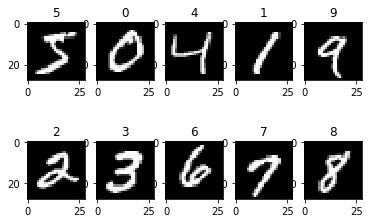

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 trained
Epoch: 1 trained
Epoch: 2 trained
Epoch: 3 trained
Epoch: 4 trained
Epoch: 5 trained
Epoch: 6 trained
Epoch: 7 trained
Epoch: 8 trained
Epoch: 9 trained
[tensor(0.2547), tensor(0.1118), tensor(0.0904), tensor(0.0791), tensor(0.0698), tensor(0.0644), tensor(0.0598), tensor(0.0557), tensor(0.0528), tensor(0.0515)]
[tensor(0.0637), tensor(0.0516), tensor(0.0408), tensor(0.0382), tensor(0.0385), tensor(0.0385), tensor(0.0320), tensor(0.0305), tensor(0.0305), tensor(0.0296)]
[0.979832268370607, 0.9830271565495208, 0.987120607028754, 0.9887180511182109, 0.9876198083067093, 0.9877196485623003, 0.9900159744408946, 0.9898162939297125, 0.9903154952076677, 0.9912140575079872]


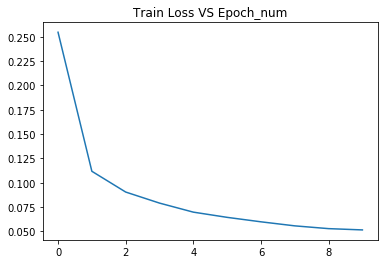

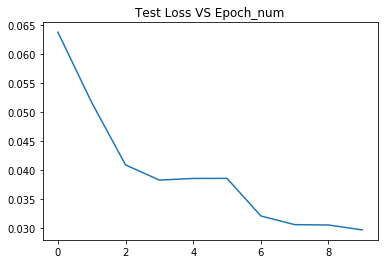

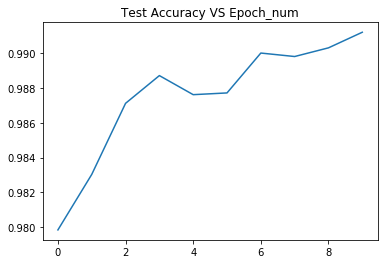

class0Accuracy : 0.996938775510204
class1Accuracy : 0.9955947136563876
class2Accuracy : 0.9922480620155039
class3Accuracy : 0.995049504950495
class4Accuracy : 0.9908350305498982
class5Accuracy : 0.9820627802690582
class6Accuracy : 0.9906054279749478
class7Accuracy : 0.9922178988326849
class8Accuracy : 0.9887063655030801
class9Accuracy : 0.9861248761149654


In [4]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

def train(trainloader, optimizer, criterion, epoch, net):
    """ Function to train the model
        Arguments:
            trainloader: Dataloader for train dataset
            optimizer: Optimizer for training
            criterion : loss function
            epoch: epoch number
            net: Network instance

        Returns:
            train_loss (list): training loss after 1 pass over the entire training data

     TO-DO:
     1. Enumerate over the trainloader
     2. Do forward prop and backprop
     3. Store the loss after each iteration
     4. Return mean training loss for the epoch
     """

    net.train()
    loss_sum = 0
    
    for i, (images, labels) in enumerate(trainloader):
        b_x = Variable(images)
        b_y = Variable(labels)
        output, f1, f2 = net(b_x)
        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        loss_sum += loss.data[0]
    train_loss_epoch = loss_sum / len(trainloader) 
    
    return train_loss_epoch, f1, f2 
    
    
def test(testloader, criterion, epoch, net):
    
    """ Function to test the model
        Arguments:
            testloader: Dataloader for test dataset
            criterion : loss function
            net: Network instance

        Returns:
            loss: mean test loss after 1 pass over the entire test data
            acc: mean test accuracy after 1 pass over the entire test data

     TO-DO:
     1. Enumerate over the testloader
     2. Do forward prop 
     3. Compute loss and accuracy
     4. Return the mean loss and accuracy after 1 pass over the entire data
     """

    net.eval()

    net.eval()
    loss_sum = 0
    accuracy = 0
    pred_y_all = np.array([])
    target_y_all = np.array([])
    
    for (images, labels) in testloader: 
        
        x = Variable(images)
        y = Variable(labels)
        
        out, f1_test, f2_test = net(x)
        
        loss = criterion(out, y)
        loss_sum += loss.data[0]
        
        _, prediction = torch.max(out, 1)
        pred_y = prediction.data.numpy().squeeze()
        
        target_y = y.data.numpy()
        accuracy += sum(pred_y == target_y) / float(target_y.size)

        if epoch == 9:
            pred_y_all = np.concatenate((pred_y_all, pred_y)) 
            target_y_all = np.concatenate((target_y_all, target_y))
            
        
    accura = accuracy / len(testloader)
    test_loss_epoch = loss_sum / len(testloader)

        
    return test_loss_epoch, accura, pred_y_all, target_y_all




def main():

    """
    Function to run the entire pipeline.

    TO-DO:
    1. Call utils.vizImages() to visualize sample training images
    2. Define the network, optimizer and criterion
    3. Train for 10 epochs
    4. Compute test loss and accuracy after each epoch
    5. Once trained, call plotLossAcc() to plot the train loss, test loss and test accuracy
    6. Call vizFeatureMaps() to visualize the feature maps
    7. Call vizConvWeights() to visualize the conv1 and conv2 kernel weights
    8. Print classwise accuracy
    9. (Optional) Save the model intermittently and load from a checkpoint
    """
    resume_checkpoint = 0
    start_epoch = 0
    max_epoch = 10
    visualize_results = 1
    
    trainset, testset, trainloader, testloader = getDataLoaders()
    vizImages(trainset)
    neural_net = Net1()
    
    optimizer = torch.optim.Adam(neural_net.parameters(), lr=0.001) # optimize all parameters
    criterion = nn.CrossEntropyLoss()
    accura = []
    train_loss = []
    test_loss = []
    
    for epoch in range(max_epoch):
        loss_train_epoch, f1, f2 = train(trainloader, 
                                         optimizer, 
                                         criterion, 
                                         epoch, 
                                         neural_net) # loss_train_epoch is tensor
        
        loss_test_epoch, accu_epoch, pred_y, target_y = test(testloader, 
                                                             criterion, 
                                                             epoch, 
                                                             neural_net) # loss_test_epoch is tensor
        train_loss.append(loss_train_epoch)
        test_loss.append(loss_test_epoch)
        accura.append(accu_epoch)
        print('Epoch: ' + str(epoch) + ' trained')
     
    print(train_loss)
    print(test_loss)
    print(accura)
    
    train_loss = torch.stack(train_loss).numpy()
    test_loss = torch.stack(test_loss).numpy()
    plotLossAcc(train_loss, test_loss, accura)
    getClassAcc(testloader, neural_net, pred_y, target_y)
    #vizConvWeights(neural_net)
    #vizFeatureMaps(testloader, neural_net, f1, f2)
    
if __name__=='__main__':
 
    main()
    
    